<a href="https://colab.research.google.com/github/amitvashista/nifty_50/blob/stage1/updated_nifty_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install matplotlib

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


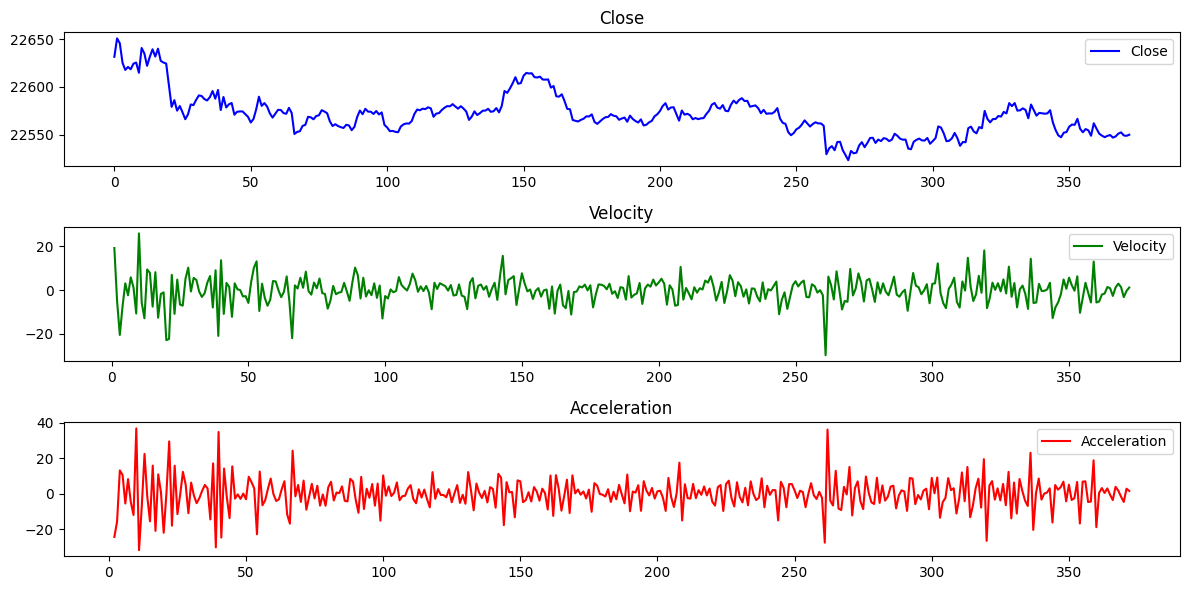

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
from datetime import datetime
import time
import requests

tz_IN = pytz.timezone('Asia/Kolkata')
today_date = datetime.today().strftime('%Y-%m-%d')

def get_nifty_option_chain():
    datetime_IN = datetime.now(tz_IN)
    url = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    with requests.Session() as session:
        session.get("https://www.nseindia.com", headers=headers)
        response = session.get(url, headers=headers)

    if response.status_code != 200:
        print("Failed to fetch data")
        return pd.DataFrame(), pd.DataFrame()

    records = response.json()['records']['data']

    CE_options = [
        {
            "Strike Price": r["CE"]["strikePrice"],
            "expiryDate": r["CE"]["expiryDate"],
            "openInterest": r["CE"]["openInterest"],
            "changeinOpenInterest": r["CE"]["changeinOpenInterest"],
            "pchangeinOpenInterest": r["CE"]["pchangeinOpenInterest"],
            "totalTradedVolume": r["CE"]["totalTradedVolume"],
            "impliedVolatility": r["CE"]["impliedVolatility"],
            "lastPrice": r["CE"]["lastPrice"],
            "change": r["CE"]["change"],
            "pChange": r["CE"]["pChange"],
            "totalBuyQuantity": r["CE"]["totalBuyQuantity"],
            "totalSellQuantity": r["CE"]["totalSellQuantity"],
            "bidQty": r["CE"]["bidQty"],
            "bidprice": r["CE"]["bidprice"],
            "askQty": r["CE"]["askQty"],
            "askPrice": r["CE"]["askPrice"],
            "underlyingValue": r["CE"]["underlyingValue"],
            "date": datetime_IN.strftime('%Y-%m-%d'),
            "Time": datetime_IN.strftime('%H-%M-%S')
        }
        for r in records if "CE" in r
    ]

    PE_options = [
        {
            "Strike Price": r["PE"]["strikePrice"],
            "expiryDate": r["PE"]["expiryDate"],
            "openInterest": r["PE"]["openInterest"],
            "changeinOpenInterest": r["PE"]["changeinOpenInterest"],
            "pchangeinOpenInterest": r["PE"]["pchangeinOpenInterest"],
            "totalTradedVolume": r["PE"]["totalTradedVolume"],
            "impliedVolatility": r["PE"]["impliedVolatility"],
            "lastPrice": r["PE"]["lastPrice"],
            "change": r["PE"]["change"],
            "pChange": r["PE"]["pChange"],
            "totalBuyQuantity": r["PE"]["totalBuyQuantity"],
            "totalSellQuantity": r["PE"]["totalSellQuantity"],
            "bidQty": r["PE"]["bidQty"],
            "bidprice": r["PE"]["bidprice"],
            "askQty": r["PE"]["askQty"],
            "askPrice": r["PE"]["askPrice"],
            "underlyingValue": r["PE"]["underlyingValue"],
            "date": datetime_IN.strftime('%Y-%m-%d'),
            "Time": datetime_IN.strftime('%H-%M-%S')
        }
        for r in records if "PE" in r
    ]

    return pd.DataFrame(CE_options), pd.DataFrame(PE_options)

# Collect data for 10 seconds
stop_time = time.time() + 60*60*5+60*30
df_nifty_CE_option_data = pd.DataFrame()
df_nifty_PE_option_data = pd.DataFrame()

while time.time() < stop_time:
    try:
        nifty_CE_option_data, nifty_PE_option_data = get_nifty_option_chain()

        if not nifty_CE_option_data.empty:
            df_nifty_CE_option_data = pd.concat([df_nifty_CE_option_data, nifty_CE_option_data], ignore_index=True)
        if not nifty_PE_option_data.empty:
            df_nifty_PE_option_data = pd.concat([df_nifty_PE_option_data, nifty_PE_option_data], ignore_index=True)

        time.sleep(1)
    except Exception as e:
        time.sleep(1)

df_nifty_CE_option_data.drop_duplicates(subset=df_nifty_CE_option_data.columns.difference(['date', 'Time']), ignore_index=True, inplace=True)
df_nifty_PE_option_data.drop_duplicates(subset=df_nifty_PE_option_data.columns.difference(['date', 'Time']), ignore_index=True, inplace=True)

def get_nifty50_data(interval='1m', period='1d'):
    nifty = '^NSEI'
    data = yf.download(nifty, interval=interval, period=period)
    data.index = data.index.tz_localize(None)  # Drop timezone to save memory
    data['Sequence'] = np.arange(1, len(data) + 1)  # Use NumPy for efficiency
    return data

def calculate_acceleration(data):
    data['Velocity'] = data['Close'].diff()
    data['Acceleration'] = data['Velocity'].diff()
    return data

def plot_acceleration(data):
    plt.figure(figsize=(12, 6))

    for i, (col, color) in enumerate(zip(["Close", "Velocity", "Acceleration"], ["blue", "green", "red"])):
        plt.subplot(3, 1, i + 1)
        plt.plot(data.index, data[col], label=col, color=color)
        plt.title(col)
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    interval, period = '1m', '1d'
    data = get_nifty50_data(interval, period)
    data = data.iloc[2:].reset_index()
    data = calculate_acceleration(data)

    numeric_cols = ["Open", "High", "Low", "Close", "Volume", "Velocity", "Acceleration"]
    data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors="coerce")

    plot_acceleration(data)

    summary_stats = data.describe()
    missing_values = data.isnull().sum()

    # Detect outliers
    Q1, Q3 = data["Acceleration"].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = data[(data["Acceleration"] < (Q1 - 1.5 * IQR)) | (data["Acceleration"] > (Q3 + 1.5 * IQR))]

    # Moving average for trends
    data["Acceleration_MA"] = data["Acceleration"].rolling(window=10, min_periods=1).mean()

# Save to Excel efficiently
df_nifty_CE_option_data.to_csv(f'NiftyOptionCE_{today_date}.csv', index=False)
df_nifty_PE_option_data.to_csv(f'NiftyOptionPE_{today_date}.csv', index=False)
data.to_csv(f"Nifty_{today_date}.csv", index=False)
